In [1]:
# !pip install gymnasium --quiet

In [2]:
!pip install --upgrade gym

In [3]:
import numpy as np
import random
import gym
import glob
import io
import matplotlib.pyplot as plt
import gym
from gym.envs.toy_text.taxi import *
import seaborn as sns
from tqdm import tqdm

In [4]:
import wandb as wb
api_key = "17dab9d1bbdc37c41831799a4b0b50d3e97400c5"

# Login to Weights & Biases
wb.login(key=api_key)
project_name = 'PA3_SMDP'

wandb: Currently logged in as: rishi1906 (iitm_aero). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
env = gym.make('Taxi-v3', render_mode="rgb_array")

In [6]:
# state space : 500 (25x5x4) discrete states
print(env.observation_space)

# action space : 6

# actions
# 0: move south
# 1: move north
# 2: move east
# 3: move west
# 4: pickup passenger
# 5: dropoff passenger

# print(env.action_space)

# Primitive Actions
# action = {0: 'move south (down)', 1: 'move north (up)', 2: 'move east (right)', 3: 'move west(left)', 4: 'pickup passenger ', 5: 'pickup passenger'}
# print(f'List of primitive actions : {action}')

seed_val = 57
start = env.reset(seed=seed_val)
print(f'Current state: {start}')

taxi_row, taxi_col, passenger_index, destination_index = env.decode(start[0])
print(f'Current state info: {taxi_row}, {taxi_col}, {passenger_index}, {destination_index}')

# Example Transitions
rnd_action = random.randint(0, 5)
# print ("Action taken:", action[rnd_action])
# env.step returns 5 tuple rather than a 4 tuple as given in the tutorial

# next_state, reward, is_terminal, _, t_prob = env.step(rnd_action)
# print (f'Transition probability: {t_prob["prob"]}')
# print (f'Next state: {next_state}')

# taxi_row, taxi_col, passenger_index, destination_index = env.decode(next_state)
# print(f'Current state info: {taxi_row}, {taxi_col}, {passenger_index}, {destination_index}')
# print (f'Reward recieved: {reward}')
# print (f'Terminal state: {is_terminal}')

Discrete(500)
Current state: (342, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})
Current state info: 3, 2, 0, 2


In [7]:
D = 0
U = 1
R = 2
L = 3

In [8]:
R_Loc = [0,0]
G_Loc = [0,4]
Y_Loc = [4,0]
B_Loc = [4,3]

In [9]:
# R_Opt_Pol = np.array(
#     [[U, L, D, D, D],
#      [U, L, L, L, L],
#      [U, L, L, L, L],
#      [U, U, U, U, U],
#      [U, U, U, U, U]])

# G_Opt_Pol = np.array(
#     [[D, D, R, R, U],
#      [R, R, R, R, U],
#      [R, R, R, R, U],
#      [U, U, U, R, U],
#      [U, U, U, R, U]])

# Y_Opt_Pol = np.array(
#     [[D, D, D, D, D],
#      [D, L, L, L, L],
#      [D, L, L, L, L],
#      [D, U, U, U, U],
#      [D, U, U, U, U]])

# B_Opt_Pol = np.array(
#     [[D, D, D, D, L],
#      [D, D, D, D, L],
#      [R, R, R, D, L],
#      [U, U, U, D, L],
#      [U, U, U, D, L]])


In [10]:
R_Opt_Pol = [[U, L, D, D, D], [U, L, D, L, L], [U, L, L, L, L], [U, U, U, U, U], [U, U, U, U, U]]
G_Opt_Pol = [[D, D, R, R, U], [R, D, R, R, U], [R, R, R, R, U], [U, U, U, R, U], [U, U, U, R, U]]
Y_Opt_Pol = [[D, D, D, D, D], [D, L, D, L, L], [D, L, L, L, L], [D, U, U, U, U], [D, U, U, U, U]]
B_Opt_Pol = [[D, D, D, D, L], [D, D, D, D, L], [R, R, R, D, L], [U, U, U, D, L], [U, U, U, D, L]]

    T_r : Taxi Row
    T_c : Taxi Col
    P_i : Passenger Index
    D_i : Destination Index

    An observation is returned as an int() that encodes the corresponding state, calculated by ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
    Ref[1]

In [11]:
def move_to_R(env, state):
    T_r, T_c, P_i, D_i = env.decode(state)
    Opt_Done = True if ([T_r, T_c] == R_Loc) else False
    Opt_Act = R_Opt_Pol[T_r][T_c]
    return [Opt_Act, Opt_Done]

In [12]:
def move_to_G(env, state):
    T_r, T_c, P_i, D_i = env.decode(state)
    Opt_Done = True if ([T_r, T_c] == G_Loc) else False
    Opt_Act = G_Opt_Pol[T_r][T_c]
    return [Opt_Act, Opt_Done]

In [13]:
def move_to_B(env, state):
    T_r, T_c, P_i, D_i = env.decode(state)
    Opt_Done = True if ([T_r, T_c] == B_Loc) else False
    Opt_Act = B_Opt_Pol[T_r][T_c]
    return [Opt_Act, Opt_Done]

In [14]:
def move_to_Y(env, state):
    T_r, T_c, P_i, D_i = env.decode(state)
    Opt_Done = True if ([T_r, T_c] == Y_Loc) else False
    Opt_Act = Y_Opt_Pol[T_r][T_c]
    return [Opt_Act, Opt_Done]

Visualize Heat Map

In [15]:
Opt = [R_Opt_Pol, G_Opt_Pol, Y_Opt_Pol, B_Opt_Pol]
Opt_Ch = ['R','G','Y','B']
labels = {0: '↓', 1: 'ꜛ', 2: '→', 3: '←'}

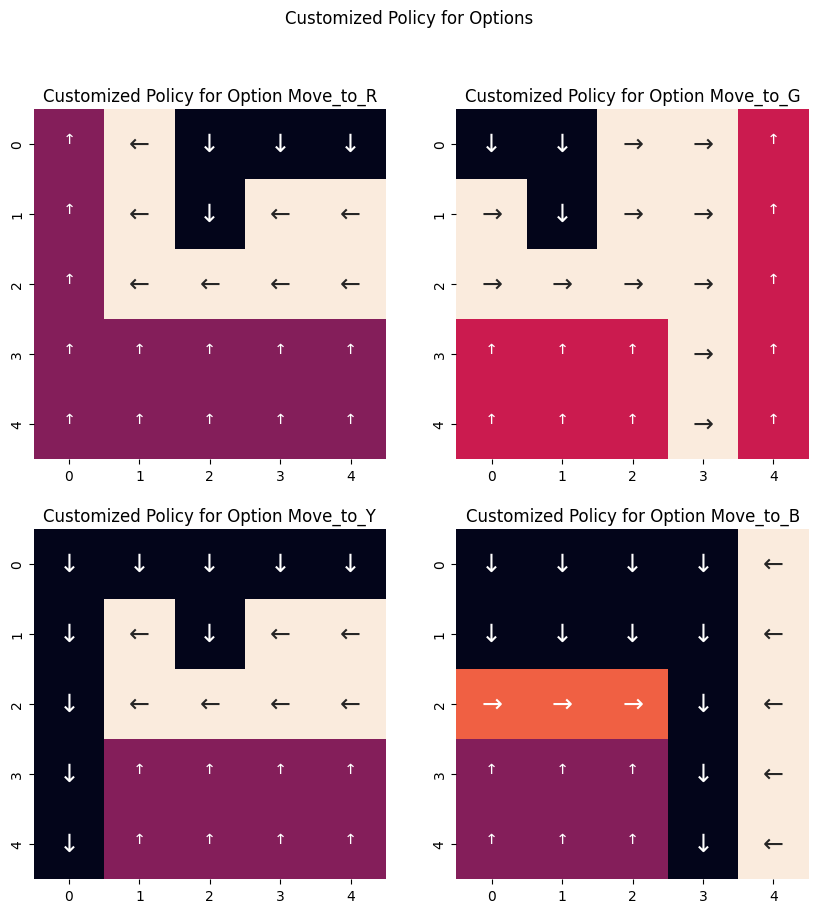

In [16]:

# sns.set_style("dark")
# custom_palette = ["#FF5733", "#FF5733", "#FF5733", "#FF5733", "#FF5733"]  # Example custom colors
# sns.set_palette(custom_palette)

fig, axis = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    for j in range(2):
        # Define custom labels for arrows

        l = np.vectorize(labels.get)(Opt[2 * i + j])

        # Plot heatmap with custom annotations
        ax = sns.heatmap(Opt[2 * i + j], ax=axis[i, j], annot=l, fmt='', cbar=False, annot_kws={"size": 18})
        axis[i, j].set_title("Customized Policy for Option Move_to_{}".format(Opt_Ch[i * 2 + j]))

plt.suptitle('Customized Policy for Options')
plt.show()


In [17]:
def epsilon_greedy(QV, stt, eps, no_act):
    action = np.random.choice(range(no_act)) if (random.uniform(0, 1) < eps) else np.argmax(QV[stt])
    return action

**SMDP Q Learning**

Lambda Expression Definitions for updating Q Values


In [18]:
# Define a function to update Q-values for primitive actions
update_q_primitive = lambda stt, act, nxt_stt, reward: \
    SMDP_QV[stt][act] + alpha * (reward + gamma * np.max(SMDP_QV[nxt_stt]) - SMDP_QV[stt][act])

update_q_option = lambda int_stt, act, tau, nxt_stt, reward_bar: \
    SMDP_QV[int_stt][act] + alpha * \
    (reward_bar + (gamma ** tau) * np.max(SMDP_QV[nxt_stt]) - SMDP_QV[int_stt][act])


In [19]:

# Define a function to perform SMDP Q-Learning for options
def smdp_q_learning_option(act_func, stt, done):
    optdone = False
    int_stt = stt
    tau = 0
    reward_bar = 0
    while (optdone == False and not done):
        optact, optdone = act_func(env, stt)
        # print(optact)
        nxt_stt, reward, done, _, _ = env.step(optact)
        reward_bar = gamma * reward_bar + reward
        tau += 1
        stt = nxt_stt
    return int_stt, tau, reward_bar, nxt_stt



In [20]:

def run_smdp_q_learning(actions_funcs, no_act,alpha, eps, exp, n_eps):
    cumulative_reward = 0
    for i in range(exp):
        for episode in tqdm(range(n_eps)):
            step = 0
            stt = env.reset()[0]
            done = False
            total_rewards = 0

            while not done:
                step += 1
                act = epsilon_greedy(SMDP_QV, stt, eps, no_act)

                if act < 6:
                    nxt_stt, reward, done, _ , _ = env.step(act)
                    total_rewards += reward
                    SMDP_QV[stt][act] = update_q_primitive(stt, act, nxt_stt, reward)
                    stt = nxt_stt

                else:
                    # print(act)
                    act_func = actions_funcs[act - 6]
                    int_stt, tau, reward_bar, nxt_stt = smdp_q_learning_option(act_func, stt, done)
                    SMDP_QV[int_stt][act] = update_q_option(int_stt, act, tau, nxt_stt, reward_bar)
                    total_rewards += reward_bar
            cumulative_reward += total_rewards
            rewards[i][episode] = total_rewards
            steps.append(step)
            r = np.sum(rewards, 0)
            mean_reward = np.mean(r)
            wb.log({'Episode_Reward': total_rewards})
            wb.log({'Episode_Step': step})
            wb.log({'Mean_Episodic_Reward': mean_reward})


In [21]:
gamma = 0.9
alpha = 0.1
n_eps = 50000
exp = 1
steps = []
no_act = 10
eps = 0.1
SMDP_QV = np.zeros((500, no_act))
rewards = np.zeros((exp, n_eps))

In [22]:
# actions = [move_to_R, move_to_G, move_to_Y, move_to_B]
# run_smdp_q_learning(actions, no_act, alpha eps, exp, n_eps)
# r = np.sum(rewards, 0)

In [23]:
!pip install wandb==0.14 -qU

Wandb Hyper Parameter Tunning


In [24]:
sweep_config={
    'method' : 'bayes' ,
    'metric' : { 'name' : 'Mean_Episodic_Reward' , 'goal' : 'maximize' } ,
    'parameters' : {
        'alpha' : { 'values' : [0.1, 0.5, 0.9] },
        'epsilon' : { 'values' : [0.1, 0.5, 0.9] },
        'episodes' : { 'values' : [1000, 3000, 5000]},
    }
}

sweep_id = wb.sweep(sweep_config, project=project_name)

Create sweep with ID: e3n5yn8d
Sweep URL: https://wandb.ai/iitm_aero/PA3_SMDP/sweeps/e3n5yn8d


In [ ]:
def train():
  with wb.init() as run:

    config = wb.config
    actions = [move_to_R, move_to_G, move_to_Y, move_to_B]
    run_smdp_q_learning(actions, no_act, config.alpha,  config.epsilon, exp, config.episodes)


wb.agent(sweep_id, function=train, count=50)
wb.finish()

wandb: Agent Starting Run: prr4jyve with config:
wandb: 	alpha: 0.9
wandb: 	episodes: 5000
wandb: 	epsilon: 0.5


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 5000/5000 [00:56<00:00, 88.23it/s] 


Episode_Reward,▆▇▇█▃▃▆▆▅▇▇██▅▆▄▇▅▆█▅▅▆█▇▆▆▅▇█▇▇█▁█▇▇▇▇▅
Episode_Step,▃▂▂▁▆▇▃▃▄▂▂▁▁▅▄▄▂▅▄▁▄▃▂▁▂▃▃▄▂▁▂▂▁█▁▂▂▂▂▃
Mean_Episodic_Reward,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Episode_Reward,-55.74524
Episode_Step,34
Mean_Episodic_Reward,-13.7408


wandb: Agent Starting Run: th1cl0qa with config:
wandb: 	alpha: 0.9
wandb: 	episodes: 5000
wandb: 	epsilon: 0.1


100%|██████████| 5000/5000 [00:28<00:00, 173.34it/s]


Episode_Reward,▁▄▅▆▄▇▂█▆▅▆▇█▇▇▆▄▇█▇▆▇▇▇▇▇▇▇▇█▆█▇█▇▆█▅▃█
Episode_Step,▇▆▄▃▅▂█▁▄▃▃▃▁▂▁▃▅▂▁▃▃▂▂▂▂▂▂▂▂▁▃▂▂▂▂▄▁▅▆▁
Mean_Episodic_Reward,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
Episode_Reward,12
Episode_Step,9
Mean_Episodic_Reward,-3.94759


wandb: Agent Starting Run: hnfdxmpd with config:
wandb: 	alpha: 0.1
wandb: 	episodes: 3000
wandb: 	epsilon: 0.1


100%|██████████| 3000/3000 [00:15<00:00, 199.13it/s]


Episode_Reward,█▇▇▅▇▇█▇█▇▆▇▇▇▆▇█▁█▄▇▆▇▄▇▂█▅▆▇▇██▇▁▂███▇
Episode_Step,▁▂▂▃▂▁▁▂▁▂▃▃▁▁▂▂▁█▁▃▂▃▃▄▂▅▁▄▃▂▂▁▁▂▆▆▁▁▁▂
Mean_Episodic_Reward,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
Episode_Reward,-19.2209
Episode_Step,23
Mean_Episodic_Reward,-2.38212


wandb: Agent Starting Run: l9nrx49k with config:
wandb: 	alpha: 0.1
wandb: 	episodes: 1000
wandb: 	epsilon: 0.1


100%|██████████| 1000/1000 [00:03<00:00, 251.03it/s]


In [ ]:
# Calculate mean and standard deviation
r = np.sum(rewards, 0)
mean_reward = np.mean(r)
std_reward = np.std(r)

In [ ]:
import matplotlib.pyplot as plt

def plot_reward_vs_episodes(n_eps, r, q_learning_type):
    plt.plot(np.arange(n_eps), r, label='Total reward')
    plt.title(f'Episode Reward vs Episodes\nMean reward = {np.mean(r):.4f}')
    plt.suptitle(f'{q_learning_type} Q-Learning with options', y=1.05)
    plt.axhline(y=np.mean(r), linestyle='--', color='orange', label='Mean Reward')
    plt.xlabel('Episodes')
    plt.ylabel('Total episode rewards')
    plt.grid()
    plt.legend()
    plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_reward(n_eps, r, rolling_mean_window=100, q_learning_type='SMDP'):
    # Calculate rolling average over the specified window size
    rolling_mean = np.convolve(r, np.ones(rolling_mean_window), 'valid') / rolling_mean_window

    # Plot rolling mean reward with a different color
    plt.plot(np.arange(rolling_mean_window - 1, n_eps), rolling_mean, label=f'Rolling Mean ({rolling_mean_window} episodes)', color='green')

    # Plot mean reward with a different color
    mean_reward = np.mean(r)
    plt.axhline(y=mean_reward, linestyle='--', color='orange', label='Mean Reward')

    # Add title and labels
    plt.title('Episode Reward vs Episodes')
    plt.suptitle(f'{q_learning_type} Q-Learning with options', y=1.05)
    plt.xlabel('Episodes')
    plt.ylabel('Total Episode Rewards')
    plt.grid()
    plt.legend()

    # Show plot
    plt.show()



In [ ]:
import matplotlib.pyplot as plt

def plot_cumulative_steps(n_eps, steps, q_learning_type='SMDP'):
    # Plot total steps
    plt.plot(np.arange(n_eps), steps, label='Total Steps', color='blue')

    # Add title and labels
    plt.title('Episode Steps vs Episodes')
    plt.suptitle(f'{q_learning_type} Q-Learning with options', y=1.05)
    plt.xlabel('Episodes')
    plt.ylabel('Total Episode Steps')
    plt.grid()
    plt.legend()

    # Show plot
    plt.show()

# Example usage:
# plot_cumulative_steps(n_eps, steps)



In [ ]:
import matplotlib.pyplot as plt

def plot_cumulative_steps_with_rolling_mean(n_eps, steps, rolling_mean_window_steps=100, q_learning_type='SMDP'):
    # Calculate mean and standard deviation for steps
    mean_steps = np.mean(steps)
    std_steps = np.std(steps)

    # Calculate rolling average over the specified window size for steps
    rolling_mean_steps = np.convolve(steps, np.ones(rolling_mean_window_steps), 'valid') / rolling_mean_window_steps

    # Plot rolling mean steps with a different color
    plt.plot(np.arange(rolling_mean_window_steps - 1, n_eps), rolling_mean_steps, label=f'Rolling Mean Steps ({rolling_mean_window_steps} episodes)', color='green')

    # Plot mean steps with a different color
    plt.axhline(y=mean_steps, linestyle='--', color='orange', label='Mean Steps')

    # Add title and labels for steps
    plt.title('Episode Steps vs Episodes')
    plt.suptitle(f'{q_learning_type} Q-Learning with options', y=1.05)
    plt.xlabel('Episodes')
    plt.ylabel('Total Episode Steps')
    plt.grid()
    plt.legend()

    # Show plot
    plt.show()



Plot Reward and Step Graphs for SMDP


In [ ]:
q_learning_type = 'SMDP'

In [ ]:
plot_reward_vs_episodes(n_eps, r, q_learning_type)

In [ ]:
plot_cumulative_reward(n_eps, r, 100, q_learning_type)

In [ ]:
plot_cumulative_steps(n_eps, steps, q_learning_type)

In [ ]:
plot_cumulative_steps_with_rolling_mean(n_eps, steps, 100, q_learning_type)

In [ ]:
import matplotlib.pyplot as plt

# Define passenger locations
passenger_locations = [0, 1, 2, 3, 4]
# Define option map and passenger map
opt_map = {0: '↓', 1: 'ꜛ', 2: '→', 3: '←', 4: 'Pick\nUp', 5: 'Drop\noff', 6: 'Go to\nR', 7: 'Go to\nY', 8: 'Go to\nG', 9: 'Go to\nB'}
pass_map = {0: 'R', 1:'G', 2: 'Y', 3:'B'}



Reshape Q Matrix to show all scenarios for SMDP

In [ ]:

# Reshape Q-values matrix
reshaped_Q_matrix = SMDP_QV.reshape(500, 10)
max_Q_matrix = np.max(reshaped_Q_matrix, axis=-1)
argmax_Q_matrix = np.argmax(reshaped_Q_matrix, axis=-1)
labeled_argmax_Q_matrix = np.vectorize(opt_map.get)(argmax_Q_matrix)

In [ ]:
def visualize_passenger_location(pass_loc, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20):
    idx = np.arange(20)
    id = idx[pass_loc * 4:pass_loc * 4 + 4]
    id_in_taxi = idx[16:20]

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(45, 40))
    plt.suptitle(f'{q_learning_type} Q Learning with the provided options', fontsize=title_font)

    for n, i in enumerate(id):
        _, _, passenger_loc, destination = env.decode(i)

        # Plot Q values for state
        axs[n][0].set_title(f'Passenger location: {pass_map[passenger_loc]}\nDestination: {pass_map[destination]}\nQ values for state', fontsize=title_font)
        sns.heatmap(max_Q_matrix[i::20].reshape(5, 5), annot=True, ax=axs[n][0])
        axs[n][0].set_ylabel(f'Episode with initial\npassenger location: {pass_map[passenger_loc]}\ndestination:{pass_map[destination]}', fontsize=ylabel_font)

        # Plot learned policy
        t = labeled_argmax_Q_matrix[i::20].reshape(5, 5)
        sns.heatmap(argmax_Q_matrix[i::20].reshape(5, 5), annot=t, fmt='', ax=axs[n][1], cbar=False)
        axs[n][1].set_title(f'Passenger location: {pass_map[passenger_loc]}\nDestination: {pass_map[destination]}\nLearned policy', fontsize=title_font)

        # Plot Q values for state (in taxi)
        axs[n][2].set_title(f'Passenger location: In Taxi\nDestination: {pass_map[destination]}\nQ values for state', fontsize=title_font)
        sns.heatmap(max_Q_matrix[id_in_taxi[n]::20].reshape(5, 5), annot=True, ax=axs[n][2])
        t = labeled_argmax_Q_matrix[id_in_taxi[n]::20].reshape(5, 5)
        sns.heatmap(argmax_Q_matrix[id_in_taxi[n]::20].reshape(5, 5), annot=t, fmt='', ax=axs[n][3], cbar=False)
        axs[n][3].set_title(f'Passenger location: In Taxi\nDestination: {pass_map[destination]}\nLearned policy', fontsize=title_font)

        # Adjust font size of annotations for larger arrows
        for ax in axs[n]:
            for annotation in ax.texts:
                annotation.set_fontsize(26)

    plt.show()

# Example usage:
# visualize_passenger_location(pass_loc, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20)


In [ ]:
# Call the function with the desired passenger location
visualize_passenger_location(0, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(1, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20)


In [ ]:
visualize_passenger_location(2, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20)


In [ ]:
visualize_passenger_location(3, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20)

In [ ]:
# def visualize_all_passenger_locations():
#     for pass_loc in range(4):
#         visualize_passenger_location(pass_loc)

# Call the function to visualize all possible passenger locations
# visualize_all_passenger_locations()


 **Intra-Option Q-Learning**

In [ ]:
update_option = lambda nxt_stt, optdone, act: ((optdone) * np.max(IOQL_QV[nxt_stt]) + (1 - optdone) * (IOQL_QV[nxt_stt][act]))


In [ ]:
gamma = 0.9
alpha = 0.1
n_eps = 50000
exp = 1
steps = []
IOQL_rewards = np.zeros((exp, n_eps))
max_eps = 0.1
eps_decay=1
eps_min=0.01
eps_ = max_eps
no_act = 10
IOQL_QV = np.zeros((500, no_act))

In [ ]:
from tqdm import tqdm

def run_IOQL(env, IOQL_QV, action_funcs, eps_min, eps_, eps_decay, alpha, gamma, exp, n_eps, no_act):
    for i in range(exp):
        for episode in tqdm(range(n_eps)):
            step = 0
            stt = env.reset()[0]
            done = False
            total_rewards = 0
            # eps = eps_

            while not done:
                step += 1
                eps = min(eps_min, eps_)
                act = epsilon_greedy(IOQL_QV, stt, eps, no_act)
                eps_ *= eps_decay

                if act < 6:
                    nxt_stt, reward, done, _, _ = env.step(act)
                    total_rewards += reward
                    IOQL_QV[stt][act] += alpha * (reward + gamma * np.max(IOQL_QV[nxt_stt]) - IOQL_QV[stt][act])
                    stt = nxt_stt
                else:
                    act_func = action_funcs[act - 6]
                    optdone = False
                    int_stt = stt
                    tau = 0
                    reward_bar = 0

                    while not (optdone or done):
                        optact, optdone = act_func(env, stt)
                        next_stt, reward, done, _, _ = env.step(optact)

                        IOQL_QV[stt][optact] += alpha * (reward + gamma * np.max(IOQL_QV[next_stt]) - IOQL_QV[stt][optact])
                        IOQL_QV[stt][act] += alpha * (reward + gamma * update_option(next_stt, optdone, act) - IOQL_QV[stt][act])
                        taxi_row, taxi_col, passenger_index, destination_index = env.decode(stt)
                        sim_opt = act + 1 if (act % 2) == 0 else act - 1

                        if taxi_col > 0 and (act==6 or act==7):
                            IOQL_QV[stt][sim_opt] += alpha * (reward + gamma * np.max(IOQL_QV[next_stt]) - IOQL_QV[stt][sim_opt])
                        elif taxi_col < 3 and (act==8 or act==9):
                            IOQL_QV[stt][sim_opt] += alpha * (reward + gamma * np.max(IOQL_QV[next_stt]) - IOQL_QV[stt][sim_opt])
                        reward_bar = gamma * reward_bar + reward
                        stt = next_stt

                    total_rewards += reward_bar

            IOQL_rewards[i][episode] = total_rewards
            steps.append(step)




In [ ]:


action_funcs = [move_to_R, move_to_G, move_to_Y, move_to_B]
run_IOQL(env, IOQL_QV, action_funcs, eps_min, eps_, eps_decay, alpha, gamma, exp, n_eps, no_act)
r = np.sum(IOQL_rewards, 0)

In [ ]:
# Calculate mean and standard deviation
mean_reward = np.mean(r)
std_reward = np.std(r)

In [ ]:
q_learning_type = 'Intra Option'

In [ ]:
plot_reward_vs_episodes(n_eps, r, q_learning_type)

In [ ]:
plot_cumulative_reward(n_eps, r, 100, q_learning_type)

In [ ]:
plot_cumulative_steps(n_eps, steps, q_learning_type)

In [ ]:
plot_cumulative_steps_with_rolling_mean(n_eps, steps, 100, q_learning_type)

Reshape Q Matrix to show all scenarios for Intra Option Q Learning


In [ ]:
reshaped_IOQL_matrix = IOQL_QV.reshape(500, no_act)
argmax_IOQL_matrix = np.argmax(reshaped_IOQL_matrix, axis=-1)
max_IOQL_matrix = np.max(reshaped_IOQL_matrix, axis=-1)
labeled_argmax_IOQL_matrix = np.vectorize(opt_map.get)(argmax_IOQL_matrix)

Plot heatmaps for IOQL


In [ ]:
visualize_passenger_location(0, max_IOQL_matrix, argmax_IOQL_matrix, labeled_argmax_IOQL_matrix, q_learning_type='Intra Option', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(1, max_IOQL_matrix, argmax_IOQL_matrix, labeled_argmax_IOQL_matrix, q_learning_type='Intra Option', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(2, max_IOQL_matrix, argmax_IOQL_matrix, labeled_argmax_IOQL_matrix, q_learning_type='Intra Option', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(3, max_IOQL_matrix, argmax_IOQL_matrix, labeled_argmax_IOQL_matrix, q_learning_type='Intra Option', title_font=22, ylabel_font=20)

Task 3: Alternate Options

Go to Mid point of Left Wall ie M

```
    +---------+
    |R: | : :G|
    | : | : : |
    |M: : : : |
    | | : | : |
    |Y| : |B: |
    +---------+


```


Go to Mid point of Right Wall ie N

```
    +---------+
    |R: | : :G|
    | : | : : |
    | : : : :N|
    | | : | : |
    |Y| : |B: |
    +---------+

```




In [ ]:
M_Loc = [2,0]
N_Loc = [2,4]

In [ ]:
M_Opt_Pol = np.array([[D, D, D, D, D],
                 [D, D, D, D, D],
                 [L, L, L, L, L],
                 [U, U, U, U, U],
                 [U, U, U, U, U]])

N_Opt_Pol = np.array([[D, D, D, D, D],
                  [D, D, D, D, D],
                  [R, R, R, R, R],
                  [U, U, U, U, U],
                  [U, U, U, U, U]])


In [ ]:
def move_to_M(env, state):
    T_r, T_c, P_i, D_i = env.decode(state)
    Opt_Done = True if ([T_r, T_c] == M_Loc) else False
    Opt_Act = M_Opt_Pol[T_r][T_c]
    return [Opt_Act, Opt_Done]

In [ ]:
def move_to_N(env, state):
    T_r, T_c, P_i, D_i = env.decode(state)
    Opt_Done = True if ([T_r, T_c] == N_Loc) else False
    Opt_Act = N_Opt_Pol[T_r][T_c]
    return [Opt_Act, Opt_Done]

In [ ]:

options = [M_Opt_Pol, N_Opt_Pol]
optName = ['left_wall_center','right_wall_center']

figure, axis = plt.subplots(1,2,figsize=(15,10))

i=0
labels = {0: '↓', 1: 'ꜛ', 2: '→', 3: '←'}
for j in range(2):
    # labels = {0:'south',1:'north', 2:'east', 3:'west'}
    l = np.vectorize(labels.get)((options[2*i+j]))
    sns.heatmap((options[2*i+j]),ax=axis[j],annot = l,fmt='', cbar=False, annot_kws={"size": 18})
    axis[j].set_title("Policy for option go_to_{}".format(optName[i*2+j]))
plt.suptitle(f'Policy for the new options')



In [ ]:
gamma = 0.9
alpha = 0.1
n_eps = 30000
exp = 1
steps = []
eps = 0.1
no_act = 8
SMDP_QV = np.zeros((500, no_act))
rewards = np.zeros((exp, n_eps))

In [ ]:
# Define a function to update Q-values for primitive actions
update_q_primitive = lambda stt, act, nxt_stt, reward: \
    SMDP_QV[stt][act] + alpha * (reward + gamma * np.max(SMDP_QV[nxt_stt]) - SMDP_QV[stt][act])

update_q_option = lambda int_stt, act, tau, nxt_stt, reward_bar: \
    SMDP_QV[int_stt][act] + alpha * \
    (reward_bar + (gamma ** tau) * np.max(SMDP_QV[nxt_stt]) - SMDP_QV[int_stt][act])


In [ ]:

# Define a function to perform SMDP Q-Learning for options
def smdp_q_learning_option_MN(act_func, stt, done):
    optdone = False
    int_stt = stt
    tau = 0
    reward_bar = 0
    while (optdone == False and not done):
        optact, optdone = act_func(env, stt)
        # print(optact)
        nxt_stt, reward, done, _, _ = env.step(optact)
        reward_bar = gamma * reward_bar + reward
        tau += 1
        stt = nxt_stt
    return int_stt, tau, reward_bar, nxt_stt



In [ ]:

def run_smdp_q_learning_MN(actions_funcs, no_act, eps, exp, n_eps):

    for i in range(exp):
        for episode in tqdm(range(n_eps)):
            step = 0
            stt = env.reset()[0]
            done = False
            total_rewards = 0

            while not done:
                step += 1
                act = epsilon_greedy(SMDP_QV, stt, eps, no_act)

                if act < 6:
                    nxt_stt, reward, done, _ , _ = env.step(act)
                    total_rewards += reward
                    SMDP_QV[stt][act] = update_q_primitive(stt, act, nxt_stt, reward)
                    stt = nxt_stt

                else:
                    # print(act)
                    act_func = actions_funcs[act - 6]
                    int_stt, tau, reward_bar, nxt_stt = smdp_q_learning_option_MN(act_func, stt, done)
                    SMDP_QV[int_stt][act] = update_q_option(int_stt, act, tau, nxt_stt, reward_bar)
                    total_rewards += reward_bar

            rewards[i][episode] = total_rewards
            steps.append(step)


In [ ]:
# actions_fun = [move_to_R, move_to_G, move_to_Y, move_to_B, move_to_M, move_to_N]
actions_fun = [move_to_M, move_to_N]
run_smdp_q_learning_MN(actions_fun, no_act, eps, exp, n_eps)
r = np.sum(rewards, 0)

In [ ]:
# Calculate mean and standard deviation
mean_reward = np.mean(r)
std_reward = np.std(r)

Plot Reward and Step Graphs for SMDP


In [ ]:
q_learning_type = 'SMDP'

In [ ]:
plot_reward_vs_episodes(n_eps, r, q_learning_type)

In [ ]:
plot_cumulative_reward(n_eps, r, 100, q_learning_type)

In [ ]:
plot_cumulative_steps(n_eps, steps, q_learning_type)

In [ ]:
plot_cumulative_steps_with_rolling_mean(n_eps, steps, 100, q_learning_type)

In [ ]:
import matplotlib.pyplot as plt

# Define passenger locations
passenger_locations = [0, 1, 2, 3, 4]
# Define option map and passenger map
opt_map = {0: '↓', 1: 'ꜛ', 2: '→', 3: '←', 4: 'Pick\nUp', 5: 'Drop\noff', 6: 'Go to\nM', 7: 'Go to\nN'}
pass_map = {0: 'R', 1:'G', 2: 'Y', 3:'B'}



Reshape Q Matrix to show all scenarios for SMDP

In [ ]:
# Reshape Q-values matrix
reshaped_Q_matrix = SMDP_QV.reshape(500, no_act)
max_Q_matrix = np.max(reshaped_Q_matrix, axis=-1)
argmax_Q_matrix = np.argmax(reshaped_Q_matrix, axis=-1)
labeled_argmax_Q_matrix = np.vectorize(opt_map.get)(argmax_Q_matrix)

In [ ]:
visualize_passenger_location(0, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(1, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(2, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(3, max_Q_matrix, argmax_Q_matrix, labeled_argmax_Q_matrix, q_learning_type='SMDP', title_font=22, ylabel_font=20)

Intra Option Q Learning for Mid Left and Mid Right Options

In [ ]:
update_option = lambda nxt_stt, optdone, act: ((optdone) * np.max(IOQL_QV[nxt_stt]) + (1 - optdone) * (IOQL_QV[nxt_stt][act]))


In [ ]:
from tqdm import tqdm

def run_IOQL_MN(env, IOQL_QV, action_funcs, eps_min, eps_, eps_decay, alpha, gamma, exp, n_eps, no_act):
    for i in range(exp):
        for episode in tqdm(range(n_eps)):
            step = 0
            stt = env.reset()[0]
            done = False
            total_rewards = 0
            # eps = eps_

            while not done:
                step += 1
                eps = min(eps_min, eps_)
                act = epsilon_greedy(IOQL_QV, stt, eps, no_act)
                eps_ *= eps_decay

                if act < 6:
                    nxt_stt, reward, done, _, _ = env.step(act)
                    total_rewards += reward
                    IOQL_QV[stt][act] += alpha * (reward + gamma * np.max(IOQL_QV[nxt_stt]) - IOQL_QV[stt][act])
                    stt = nxt_stt
                else:
                    act_func = action_funcs[act - 6]
                    optdone = False
                    int_stt = stt
                    tau = 0
                    reward_bar = 0

                    while not (optdone or done):
                        optact, optdone = act_func(env, stt)
                        next_stt, reward, done, _, _ = env.step(optact)

                        IOQL_QV[stt][optact] += alpha * (reward + gamma * np.max(IOQL_QV[next_stt]) - IOQL_QV[stt][optact])
                        IOQL_QV[stt][act] += alpha * (reward + gamma * update_option(next_stt, optdone, act) - IOQL_QV[stt][act])
                        taxi_row, taxi_col, passenger_index, destination_index = env.decode(stt)

                        sim_opt = act + 1 if (act % 2) == 0 else act - 1

                        # if (taxi_row < 2) or (taxi_row > 2) and (act==6):
                        #     IOQL_QV[stt][sim_opt] += alpha * (reward + gamma * np.max(IOQL_QV[next_stt]) - IOQL_QV[stt][sim_opt])
                        # elif (taxi_row < 2) or (taxi_row > 2) and (act==7):
                        #     IOQL_QV[stt][sim_opt] += alpha * (reward + gamma * np.max(IOQL_QV[next_stt]) - IOQL_QV[stt][sim_opt])
                        reward_bar = gamma * reward_bar + reward
                        stt = next_stt

                    total_rewards += reward_bar

            IOQL_rewards[i][episode] = total_rewards
            steps.append(step)




In [ ]:
gamma = 0.9
alpha = 0.1
n_eps = 50000
exp = 1
steps = []
IOQL_rewards = np.zeros((exp, n_eps))
max_eps = 0.1
eps_decay=1
eps_min=0.01
eps_ = max_eps
no_act = 8
IOQL_QV = np.zeros((500, no_act))

In [ ]:


action_funcs = [move_to_R, move_to_G, move_to_Y, move_to_B]
run_IOQL_MN(env, IOQL_QV, action_funcs, eps_min, eps_, eps_decay, alpha, gamma, exp, n_eps, no_act)
r = np.sum(IOQL_rewards, 0)

In [ ]:
# Calculate mean and standard deviation
mean_reward = np.mean(r)
std_reward = np.std(r)

In [ ]:
q_learning_type = 'Intra Option'

In [ ]:
plot_reward_vs_episodes(n_eps, r, q_learning_type)

In [ ]:
plot_cumulative_reward(n_eps, r, 100, q_learning_type)

In [ ]:
plot_cumulative_steps(n_eps, steps, q_learning_type)

In [ ]:
plot_cumulative_steps_with_rolling_mean(n_eps, steps, 100, q_learning_type)

Reshape Q Matrix to show all scenarios for Intra Option Q Learning


In [ ]:
reshaped_IOQL_matrix = IOQL_QV.reshape(500, no_act)
argmax_IOQL_matrix = np.argmax(reshaped_IOQL_matrix, axis=-1)
max_IOQL_matrix = np.max(reshaped_IOQL_matrix, axis=-1)
labeled_argmax_IOQL_matrix = np.vectorize(opt_map.get)(argmax_IOQL_matrix)

Plot heatmaps for IOQL


In [ ]:
visualize_passenger_location(0, max_IOQL_matrix, argmax_IOQL_matrix, labeled_argmax_IOQL_matrix, q_learning_type='Intra Option', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(1, max_IOQL_matrix, argmax_IOQL_matrix, labeled_argmax_IOQL_matrix, q_learning_type='Intra Option', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(2, max_IOQL_matrix, argmax_IOQL_matrix, labeled_argmax_IOQL_matrix, q_learning_type='Intra Option', title_font=22, ylabel_font=20)

In [ ]:
visualize_passenger_location(3, max_IOQL_matrix, argmax_IOQL_matrix, labeled_argmax_IOQL_matrix, q_learning_type='Intra Option', title_font=22, ylabel_font=20)

References:

[1] : https://gymnasium.farama.org/environments/toy_text/taxi/